# Volume Normalization Experiment (TSLA)

Goal: Visualize volume skew in the 96-day training window (starting 2025-02-01), then normalize inputs (log1p + scaler), save a normalized CSV, and compare model performance (TFT Baseline / TFT + Reddit).



In [1]:
# Setup
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import skew, kurtosis

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'tsla_price_sentiment_spike.csv')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

print('Project root:', PROJECT_ROOT)
print('Data path:', DATA_PATH)


Project root: /Users/hwang-yejin/Desktop/Financial Time Series Forecasting with Deep Learning Models and Social Media Sentiment
Data path: /Users/hwang-yejin/Desktop/Financial Time Series Forecasting with Deep Learning Models and Social Media Sentiment/data/processed/tsla_price_sentiment_spike.csv


In [2]:
# Load data and slice 96-day training window starting 2025-02-01
import pandas as pd

df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
start_dt = pd.to_datetime('2025-02-01')
# Find first index >= start_dt
start_idx = df.index[df['date'] >= start_dt]
start_idx = int(start_idx[0]) if len(start_idx) > 0 else 0
training_days = 96
pred_days = 5
total_rows = training_days + pred_days
end_idx = min(start_idx + total_rows, len(df))

df_slice = df.iloc[start_idx:end_idx].copy()
print(df_slice[['date','close','volume']].head())
print('Slice rows:', len(df_slice))


          date       close    volume
128 2025-02-03  383.679993  93732100
129 2025-02-04  392.209992  57072200
130 2025-02-05  378.170013  57223300
131 2025-02-06  374.320007  77918200
132 2025-02-07  361.619995  70298300
Slice rows: 101


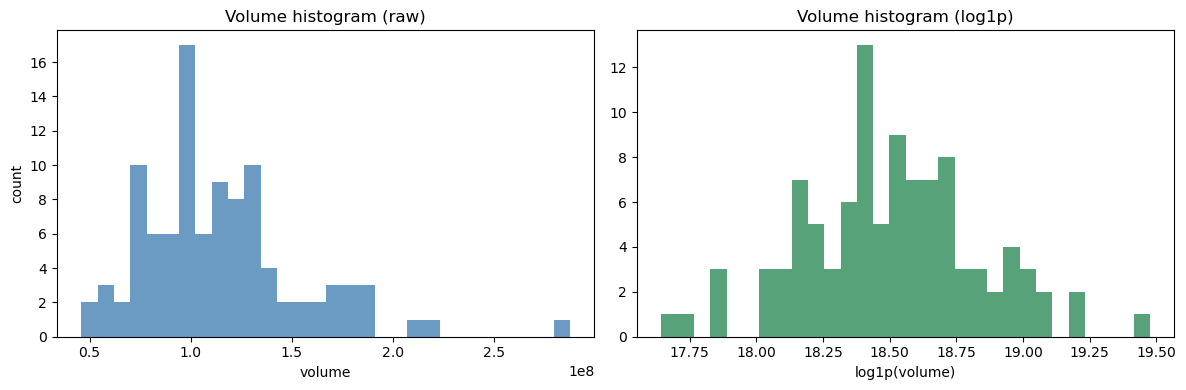

Raw  skew: 1.2569507271289737
Raw  kurt: 2.7311096970284003
Log1p skew: 0.08295134247233231
Log1p kurt: 0.24388110148002928


In [3]:
# Visualize volume distribution and skew/kurtosis
v = df_slice['volume'].astype(float)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(v, bins=30, color='steelblue', alpha=0.8)
axes[0].set_title('Volume histogram (raw)')
axes[0].set_xlabel('volume')
axes[0].set_ylabel('count')

v_log = np.log1p(v)
axes[1].hist(v_log, bins=30, color='seagreen', alpha=0.8)
axes[1].set_title('Volume histogram (log1p)')
axes[1].set_xlabel('log1p(volume)')
plt.tight_layout()
plt.show()

print('Raw  skew:', float(skew(v, nan_policy='omit')))
print('Raw  kurt:', float(kurtosis(v, nan_policy='omit')))
print('Log1p skew:', float(skew(v_log, nan_policy='omit')))
print('Log1p kurt:', float(kurtosis(v_log, nan_policy='omit')))


In [4]:
# Fit scaler on train-only window and save normalized CSV
from sklearn.preprocessing import StandardScaler, RobustScaler

# Train/val/test split within the slice: first 96 train, last 5 forecast horizon
train_df = df_slice.iloc[:training_days].copy()
pred_df = df_slice.iloc[training_days:].copy()

# Choose scaler; use RobustScaler by default for heavy tails
use_robust = True
scaler = RobustScaler() if use_robust else StandardScaler()

# Log1p transform volume, then fit on train
train_df['volume_log1p'] = np.log1p(train_df['volume'].astype(float))
scaler.fit(train_df[['volume_log1p']])

# Apply to full slice, create normalized column
full = df_slice.copy()
full['volume_log1p'] = np.log1p(full['volume'].astype(float))
full['volume_norm'] = scaler.transform(full[['volume_log1p']])

# Save a normalized copy for entire dataset (not just slice) to reuse in pipelines
normalized_df = df.copy()
normalized_df['volume_log1p'] = np.log1p(normalized_df['volume'].astype(float))
normalized_df['volume_norm'] = scaler.transform(
    normalized_df[['volume_log1p']].fillna(method='ffill').fillna(method='bfill')
)

out_csv = os.path.join(PROJECT_ROOT, 'data', 'processed', 'tsla_price_sentiment_spike_norm.csv')
normalized_df.to_csv(out_csv, index=False)
print('Saved normalized dataset to:', out_csv)


Saved normalized dataset to: /Users/hwang-yejin/Desktop/Financial Time Series Forecasting with Deep Learning Models and Social Media Sentiment/data/processed/tsla_price_sentiment_spike_norm.csv


/var/folders/pq/ywh3rrys6n9dnn8yfd90rznm0000gn/T/ipykernel_11575/3323043538.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  normalized_df[['volume_log1p']].fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Optional: quick A/B run hooks (manual)
print('\nNext steps:')
print('1) In TFT notebooks, point DATA_PATH to tsla_price_sentiment_spike_norm.csv')
print('2) Re-run TFT Baseline & TFT + Reddit to compare RMSE/MAPE with/without volume_norm')


Next steps:
1) In TFT notebooks, point DATA_PATH to tsla_price_sentiment_spike_norm.csv
2) Re-run TFT Baseline & TFT + Reddit to compare RMSE/MAPE with/without volume_norm
